# Plot MISOMIP IceOcean1 results for MOM6-IS

In [1]:
%matplotlib inline

import xarray as xr
import tkinter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import os

## Read in the ice sheet and ocean results

In [2]:
ds_is=xr.open_dataset('./combined_1r_1ra/combined_ice_shelf_month_001-200.nc')
ds_ocn=xr.open_dataset('./combined_1r_1ra/combined_ocean_month_001-200.nc')
#Remove length attributes to make it easier to read
ds_is.attrs={}; ds_ocn.attrs={}

In [3]:
ds_is_av=xr.open_dataset('./combined_1r_1ra/combined_ice_shelf_month_av_001-200.nc')
ds_ocn_av=xr.open_dataset('./combined_1r_1ra/combined_ocean_month_av_001-200.nc')
ds_is_av.attrs={}; ds_ocn_av.attrs={}

/net/Alexander.Huth/miniconda3/envs/my-python-311-jupyter/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/net/Alexander.Huth/miniconda3/envs/my-python-311-jupyter/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
ds_is_scalar = xr.open_dataset('./combined_1r_1ra/ice_shelf_scalar_001-200.nc')
ds_is_scalar=ds_is_scalar.squeeze(drop=True)
ds_is_scalar.attrs={};

### Modified plotting routes from Gustavo and M6toolbox 

In [5]:
def section2quadmesh(x, z, q, representation='pcm'):
  """
  Creates the appropriate quadmesh coordinates to plot a scalar q(1:nk,1:ni) at
  horizontal positions x(1:ni+1) and between interfaces at z(nk+1,ni), using
  various representations of the topography.

  Returns X(2*ni+1), Z(nk+1,2*ni+1) and Q(nk,2*ni) to be passed to pcolormesh.

  TBD: Optionally, x can be dimensioned as x(ni) in which case it will be extraplated as if it had 
  had dimensions x(ni+1).
  
  Optional argument:
  
  representation='pcm' (default) yields a step-wise visualization, appropriate for
           z-coordinate models.
  representation='plm' yields a piecewise-linear visualization more representative
           of general-coordinate (and isopycnal) models.
  representation='linear' is the aesthetically most pleasing but does not
           represent the data conservatively.

  """

  if x.ndim!=1: raise Exception('The x argument must be a vector')
  if z.ndim!=2: raise Exception('The z argument should be a 2D array')
  if q.ndim!=2: raise Exception('The z argument should be a 2D array')
  qnk, qni = q.shape
  znk, zni = z.shape
  xni = x.size
  if zni!=qni: raise Exception('The last dimension of z and q must be equal in length')
  if znk!=qnk+1: raise Exception('The first dimension of z must be 1 longer than that of q. q has %i levels'%qnk)
  if xni!=qni+1: raise Exception('The length of x must 1 longer than the last dimension of q')

  if type( z ) == np.ma.core.MaskedArray: z[z.mask] = 0
  if type( q ) == np.ma.core.MaskedArray: qmin = np.amin(q); q[q.mask] = qmin

  periodicDomain =  abs((x[-1]-x[0])-360. ) < 1e-6 # Detect if horizontal axis is a periodic domain

  if representation=='pcm':
    X = np.zeros((2*qni))
    X[::2] = x[:-1]
    X[1::2] = x[1:]
    Z = np.zeros((qnk+1,2*qni))
    Z[:,::2] = z
    Z[:,1::2] = z
    Q = np.zeros((qnk,2*qni-1))
    Q[:,::2] = q
    Q[:,1::2] = ( q[:,:-1] + q[:,1:] )/2.
  elif representation=='linear':
    X = np.zeros((2*qni+1))
    X[::2] = x
    X[1::2] = ( x[0:-1] + x[1:] )/2.
    Z = np.zeros((qnk+1,2*qni+1))
    Z[:,1::2] = z
    Z[:,2:-1:2] = ( z[:,0:-1] + z[:,1:] )/2.
    Z[:,0] = z[:,0]
    Z[:,-1] = z[:,-1]
    Q = np.zeros((qnk,2*qni))
    Q[:,::2] = q
    Q[:,1::2] = q
  elif representation=='plm':
    X = np.zeros((2*qni))
    X[::2] = x[:-1]
    X[1::2] = x[1:]
    # PLM reconstruction for Z
    dz = np.roll(z,-1,axis=1) - z # Right-sided difference
    if not periodicDomain: dz[:,-1] = 0 # Non-periodic boundary
    d2 = ( np.roll(z,-1,axis=1) - np.roll(z,1,axis=1) )/2. # Centered difference
    d2 = ( dz + np.roll(dz,1,axis=1) )/2. # Centered difference
    s = np.sign( d2 ) # Sign of centered slope
    s[dz * np.roll(dz,1,axis=1) <= 0] = 0 # Flatten extrema
    dz = np.abs(dz) # Only need magnitude from here on
    S = s * np.minimum( np.abs(d2), np.minimum( dz, np.roll(dz,1,axis=1) ) ) # PLM slope
    Z = np.zeros((qnk+1,2*qni))
    Z[:,::2] = z - S/2.
    Z[:,1::2] = z + S/2.
    Q = np.zeros((qnk,2*qni-1))
    Q[:,::2] = q
    Q[:,1::2] = ( q[:,:-1] + q[:,1:] )/2.
  else: raise Exception('Unknown representation!')

  return X, Z, Q

In [6]:
def plot_section(file_handle, record, xq, j=0, variable='salt',eta='e',clim=(33.8,34.55), plot_grid=True, rep='pcm', xlim=(320,800), ylim=(-720,0), cmap=plt.cm.jet, ax=None, show_stats=True,average_it=False,ticks=None,plot_cbar=True):
    """Plots a section of by reading vertical grid and scalar variable and super-sampling
    both in order to plot vertical and horizontal reconstructions.

    Optional arguments have defaults for plotting salinity and overlaying the grid.
    """
    e = file_handle[eta][record,:,j,:].values # Vertical grid positions
    if average_it:
        s = 0.5 * (file_handle[variable][record,:,j,:].values + file_handle[variable][record,:,j+1,:].values) # Scalar field to color, at q point between h and h+1
    else:
        s = file_handle[variable][record,:,j,:].values # Scalar field to color
    
    if variable == 'u': # we need u at h pts
      s = 0.5 * (s[:,0:-1]+s[:,1::])

    x,z,q = section2quadmesh(xq, e, s, representation=rep) # This yields three areas at twice the model resolution

    if ax is None:
      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

    cmap = plt.get_cmap(cmap)
    bgrnd=(0.9,0.9,0.9)
    cs = ax.pcolormesh(x, z, q, cmap=cmap, vmin=clim[0], vmax=clim[1]);
    if plot_cbar:
        if ticks is None:
            cb =plt.colorbar(cs,ax=ax)
        else:
            cb =plt.colorbar(cs,ax=ax,ticks=ticks)

    if plot_grid: ax.plot(x, z.T, 'k');
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_yticks(np.linspace(-700,-100,7))
    ax.tick_params(bottom=True, top=True, left=True, right=True)
    for label in ax.yaxis.get_ticklabels()[1::2]:
        label.set_visible(False)

    ax.set_facecolor(bgrnd)
    if show_stats > 0:
      sMin = s.min(); sMax = s.max()
      ax.annotate('max=%.5g\nmin=%.5g'%(sMax,sMin), xy=(0.0,1.01),
      xycoords='axes fraction', verticalalignment='bottom', fontsize=10)

### Make same colormap used by Asay-Davis et al 2016

In [7]:
  def makeFerretColormap():
    red = np.array([[0,0.6],
                       [0.15,1],
                       [0.35,1],
                       [0.65,0],
                       [0.8,0],
                       [1,0.75]])
    
    green = np.array([[0,0],
                         [0.1,0],
                         [0.35,1],
                         [1,0]])
    
    
    blue = np.array([[0,0],
                       [0.5,0],
                       [0.9,0.9],
                       [1,0.9]])
    
    colorCount = 21
    ferretColorList = np.ones((colorCount,4),float)
    ferretColorList[:,0] = np.interp(np.linspace(0,1,colorCount),red[:,0],red[:,1])
    ferretColorList[:,1] = np.interp(np.linspace(0,1,colorCount),green[:,0],green[:,1])
    ferretColorList[:,2] = np.interp(np.linspace(0,1,colorCount),blue[:,0],blue[:,1])
    ferretColorList = ferretColorList[::-1,:]
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('ferret',ferretColorList,N=255)
    return cmap

In [8]:
# Just for confirming which timesteps correspong to which month/year...
# ds_ocn.time[587]

# MOM6 version of the IceOcean1 plot (Figure 13, top row, of Asay-Davis et al., 2016)

Text(0.5, 0, '$\\degree$C')

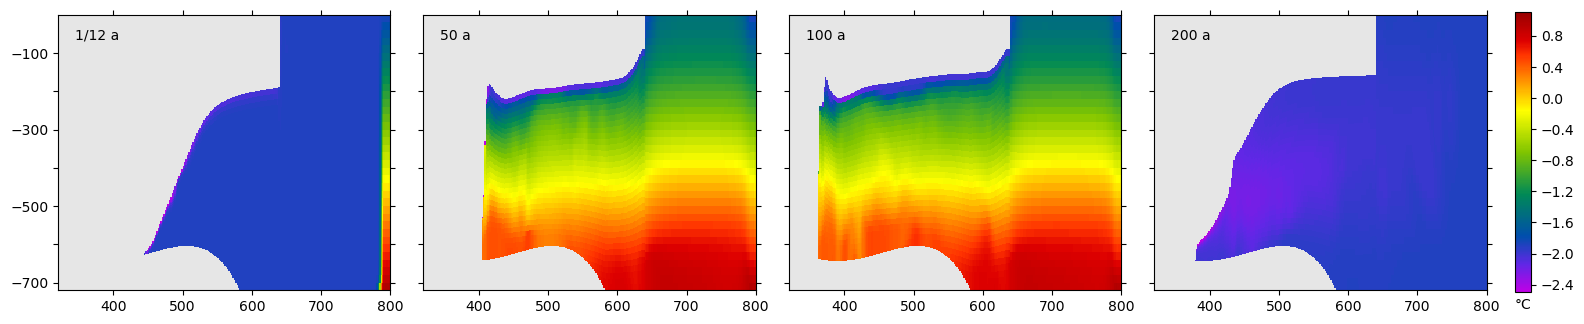

In [9]:
#Plot of ocean temperature over time
rep='pcm'
#rep='linear'
#rep='plm'
aspect_sq=(800-320)/720 #will make each subplot square
aspect_ad=(272/328)*aspect_sq #will make each subplot aspect ratio close to asay-davis et al 2016

aspect_plt = aspect_ad
ticks=np.linspace(-2.4,0.8,9)
avit=True #True to get temperature at cell boundary between cell j and j+1, e.g. if j=19, True will give the temperature at y=40 km
j=19
cmap = makeFerretColormap()
fig, axes = plt.subplots(1,4, sharex=True, sharey=True, figsize=(16, 4), dpi=100, facecolor='w')
#plt.figure(figsize=(16,9), dpi=100)
var='temp'
record = 0 #This is our first output: Feb 1, yr 0. Though I suppose we would prefer Jan 1, yr 0, it is not in our output, and we cannot use the MOM initial state file, which is missing the sponge temperature...
p1=plot_section(ds_ocn, record, ds_ocn['xq'].values, j=j, variable='temp', eta='e',clim=(-2.5,1.1), plot_grid=False, cmap=cmap, ax=axes[0], show_stats=False, average_it=avit,ticks=ticks,rep=rep,plot_cbar=False);
axes[0].set_aspect(aspect_plt)
axes[0].text(0.05, 0.925, '1/12 a', horizontalalignment='left', verticalalignment='center', transform=axes[0].transAxes)
record = 587 #Jan 1, yr 50
p2=plot_section(ds_ocn, record, ds_ocn['xq'].values, j=j, variable='temp', eta='e',clim=(-2.5,1.1), plot_grid=False, cmap=cmap, ax=axes[1], show_stats=False, average_it=avit,ticks=ticks,rep=rep,plot_cbar=False);
axes[1].set_aspect(aspect_plt)
axes[1].text(0.05, 0.925, '50 a', horizontalalignment='left', verticalalignment='center', transform=axes[1].transAxes)
record = 1187 #This is actually Jan 1, yr 100
p3=plot_section(ds_ocn, record, ds_ocn['xq'].values, j=j, variable='temp', eta='e',clim=(-2.5,1.1), plot_grid=False, cmap=cmap, ax=axes[2], show_stats=False, average_it=avit,ticks=ticks,rep=rep,plot_cbar=False);
axes[2].set_aspect(aspect_plt)
axes[2].text(0.05, 0.925, '100 a', horizontalalignment='left', verticalalignment='center', transform=axes[2].transAxes)
record = 2399 #This is actually Jan 1, yr 200
p4=plot_section(ds_ocn, record, ds_ocn['xq'].values, j=j, variable='temp', eta='e',clim=(-2.5,1.1), plot_grid=False, cmap=cmap, ax=axes[3], show_stats=False, average_it=avit,ticks=ticks,rep=rep,plot_cbar=False);
axes[3].set_aspect(aspect_plt)
axes[3].text(0.05, 0.925, '200 a', horizontalalignment='left', verticalalignment='center', transform=axes[3].transAxes)

plt.tight_layout(rect=[0, 0, 0.95, 1])
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7]) #right, up, width, height

b=fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(-2.5, 1.1),cmap=cmap), cmap=cmap, cax=cbar_ax, ticks=ticks)
b.ax.set_xlabel('$\\degree$C', labelpad=4)

### Calculate average melt rate and grounded area over time

In [10]:
f_area_int=np.sum(ds_is_av['area_shelf_h'].values*(1-ds_is_av['ice_ground_frac'].values),axis=(1,2))
melt_int=np.sum(ds_is_av['melt'].values*ds_is_av['area_shelf_h'].values,axis=(1,2))/f_area_int
g_area_int=np.sum(ds_is_av['area_shelf_h'].values*1.e-9*ds_is_av['ice_ground_frac'].values,axis=(1,2))

## Plot (top) average melt rate and (bottom) grounded ice area over time.
## This is the MOM6-IS equivalent to Fig 12 in Asay-Davis et al., 2016

Text(0.5, 0, 'Time (a)')

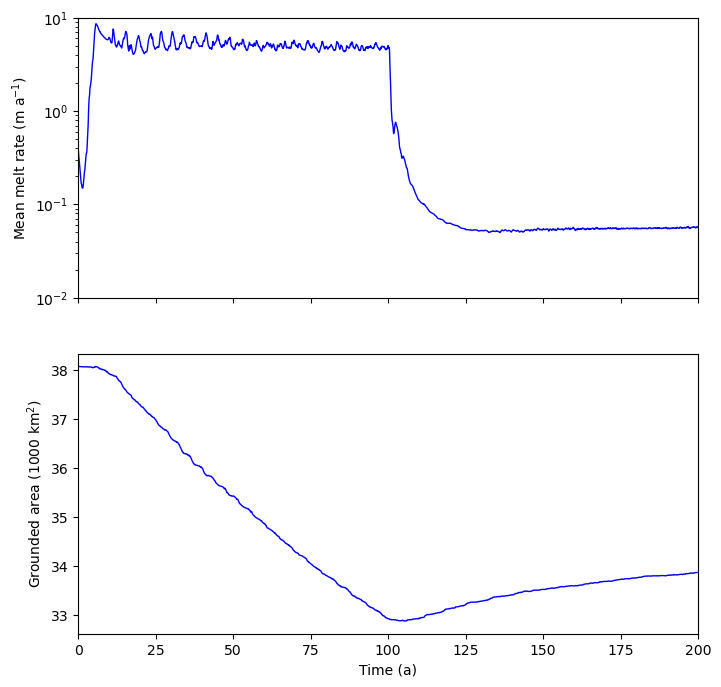

In [11]:
time=np.linspace(0,200,2400)
fig, axes = plt.subplots(2,1, sharex=True, sharey=False, figsize=(8, 8), dpi=100, facecolor='w')
line, = axes[0].plot(time, melt_int, color='blue', lw=1)
axes[0].set_yscale('log')
axes[0].set_ylim(0.2,10)
axes[0].set_xlim(0,200)
axes[0].set_yticks((0.01,0.1,1.0,10.0))
axes[0].set_ylabel('Mean melt rate (m a$^{-1}$)')


line, = axes[1].plot(time, g_area_int, color='blue', lw=1)
axes[1].set_ylabel('Grounded area (1000 km$^2$)')
axes[1].set_xlabel('Time (a)')

### Same plot, but using scalar file (less accurate)

Text(0.5, 0, 'Time (a)')

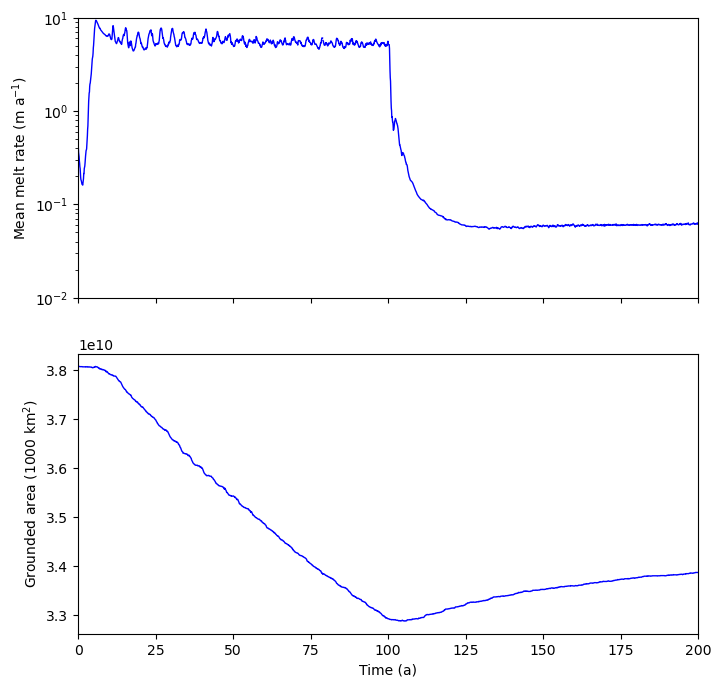

In [12]:
# Using scalar file
y2s=365*24*60*60
ds_is_scalar['mean_bdot']=-ds_is_scalar['int_bdot']/ds_is_scalar['area_float']*y2s
ds_is_scalar['mean_melt']=ds_is_scalar['int_melt']/ds_is_scalar['area_float']*y2s

fig, axes = plt.subplots(2,1, sharex=True, sharey=False, figsize=(8, 8), dpi=100, facecolor='w')
line, = axes[0].plot(time, ds_is_scalar['mean_bdot'].values, color='blue', lw=1)
axes[0].set_yscale('log')
axes[0].set_ylim(0.2,10)
axes[0].set_xlim(0,200)
axes[0].set_yticks((0.01,0.1,1.0,10.0))
axes[0].set_ylabel('Mean melt rate (m a$^{-1}$)')

line, = axes[1].plot(time, ds_is_scalar['area_ground'].values, color='blue', lw=1)
axes[1].set_ylabel('Grounded area (1000 km$^2$)')
axes[1].set_xlabel('Time (a)')